Copyright (c) 2020. Cognitive Scale Inc. All rights reserved. Licensed under CognitiveScale Example Code [License](https://github.com/CognitiveScale/cortex-certifai-examples/blob/7998b8a481fccd467463deb1fc46d19622079b0e/LICENSE.md)

# Examination of robustness and fairness on simulated datasets

In this notebook, we will use a simple example to build intuition around the Robustness and Fairness scores. To do this, we will build a variety of binary classification models to distinguish between two datasets generated from different distributions

In [2]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.neural_network import MLPClassifier
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

def plot_decision_boundary(pred_func, X, y, cmap_back=plt.cm.Spectral, cmap_points=plt.cm.Spectral, figure=None, X_cf = None, y_cf = None):
    """Plot a decision boundary"""

    if figure is None:  # If no figure is given, create a new one
        plt.figure()
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=cmap_back)
    if X_cf is None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_points)
    else:
        plt.scatter(X_cf[:, 0], X_cf[:, 1], c=y_cf, cmap=cmap_points)
    

In [3]:
# pick the palette (chosen to be accessible to people with colorblindness)
#cmap_back = ListedColormap(['#45b097','#5fa8d8']) # seafoam and blue
#cmap_back = ListedColormap(['#d17d10', '#5fa8d8']) # orange and blue
cmap_back = ListedColormap(['#d17d10','#94c8eb']) # orange and lighter blue

#cm_bright = ListedColormap(['#f1a340', '#2C7FB8']) # orange and blue
cm_bright = ListedColormap(['#f1a340', '#256a98']) # orange and darker blue
#cm_bright = ListedColormap(['#45b097','#d17d10']) # seafoam and orange


## Generate training and test datasets

Let's generate a simple dataset in two dimensions, so it's easy to visualize. We will use the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function from  [scikit-learn](http://scikit-learn.org/).

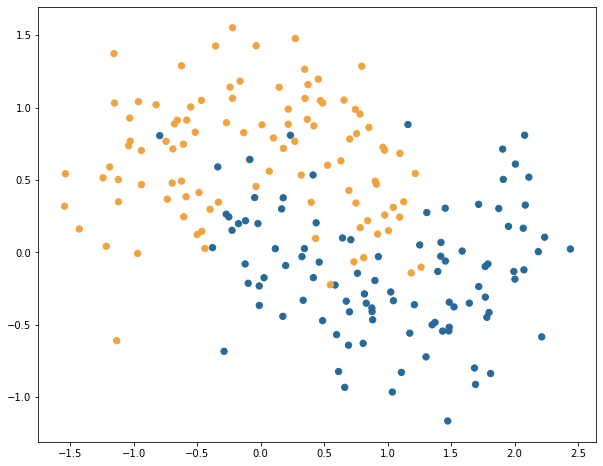

In [4]:
# Generate a training dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.30)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=cm_bright)
plt.show()


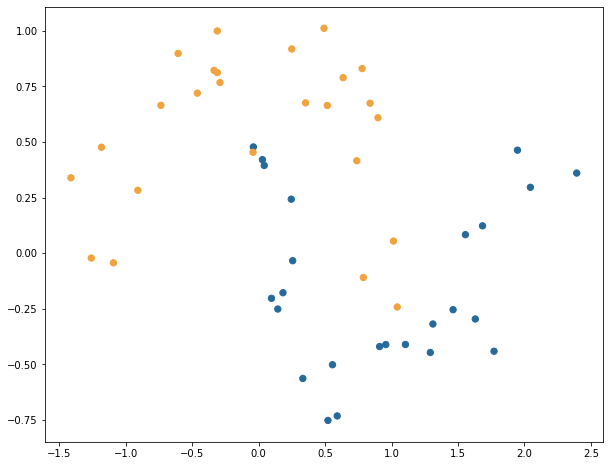

In [5]:
# Here's the test data
X_test, y_test = sklearn.datasets.make_moons(50, noise=0.20)
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=cm_bright)
plt.show()

In [6]:
# prep data for Certifai by adding the outcome column to the x, y coordinates
df = pd.DataFrame(X, columns=['income', 'credit_score'])
df['outcome'] = y

df_test = pd.DataFrame(X_test, columns=['income', 'credit_score'])
df_test['outcome'] = y_test


In [7]:
# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(0, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

### Fitting the models

Our goal is to train a model that will be able to classify the orange dots as class 0 and the blue dots as class 1 as accurately as possible while also balancing concerns like robustness and fairness. We will use a Multilayer Perceptron (MLP), which is a simple neural network, to classify these points. As with any modeling problem, we want to maximize performance on the training set but also set the model up to perform well on future, unseen data. That is, we want to avoid overfitting, and so we will fit a whole set of models varying parameters, looking for a model that balances these two aims.

We will tune the alpha parameter on the MLP, which controls how closely the model fits to the training data. Since our dataset only has two variables, we can quickly assess how complex the model is by plotting the boundary the MLP arrives at for different values of alpha.

In the figure below, we’ve drawn in the decision boundary and colored the region with the label that the model gives to points that lie in this region. For example, if a point is in the blue region, the model labels it as a 1. The dots are colored with their actual label, so if a red dot is in the blue region (or vice versa) that means the model has misclassified it. 

Alpha:  1e-05 , Training accuracy:  0.995 , Test accuracy: 0.92
Alpha:  0.001 , Training accuracy:  0.99 , Test accuracy: 0.84
Alpha:  0.01 , Training accuracy:  0.99 , Test accuracy: 0.9
Alpha:  0.1 , Training accuracy:  0.995 , Test accuracy: 0.94
Alpha:  1 , Training accuracy:  0.92 , Test accuracy: 0.94
Alpha:  10 , Training accuracy:  0.83 , Test accuracy: 0.86


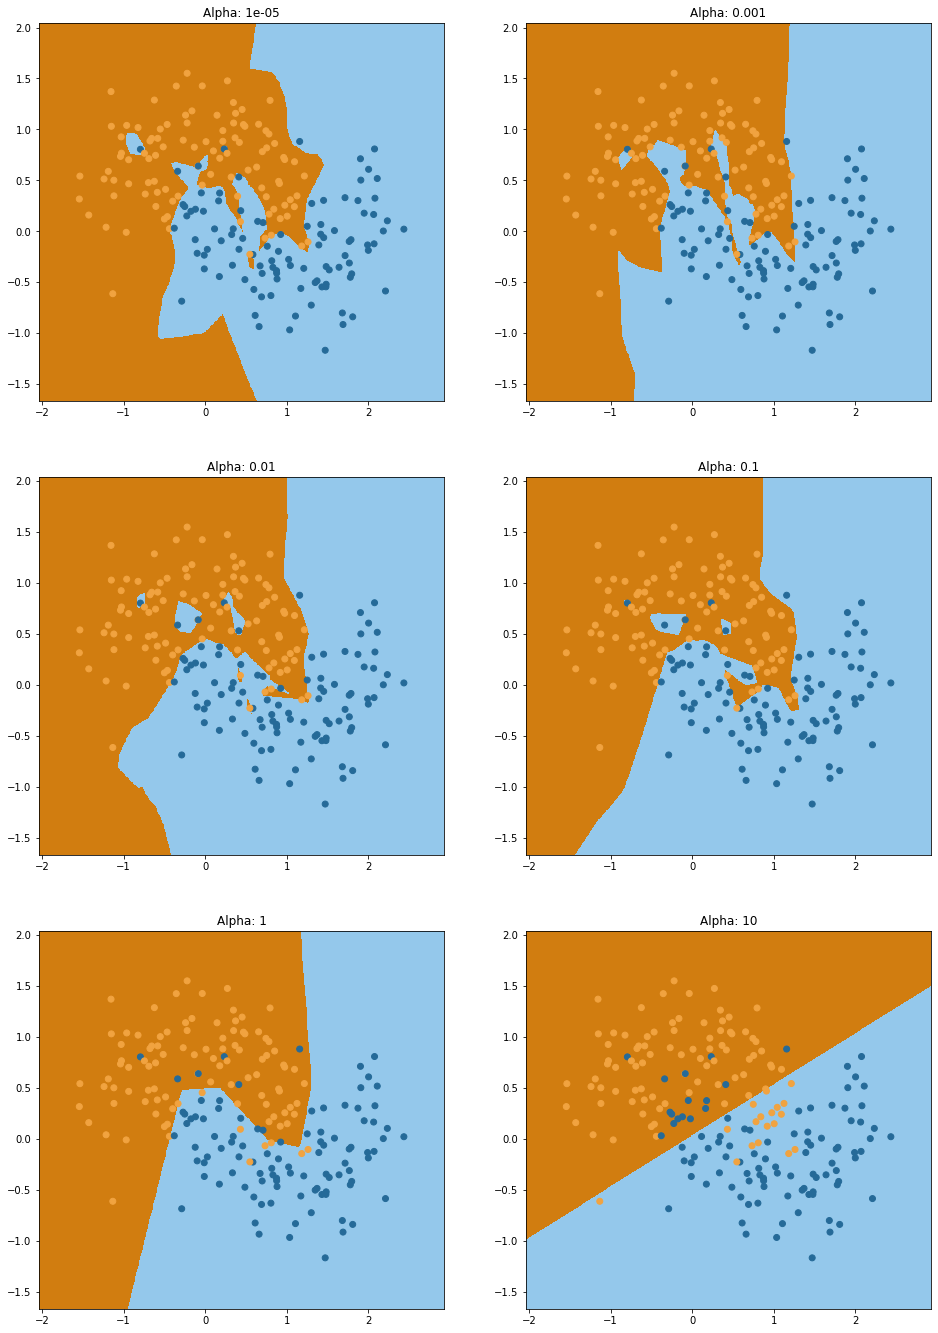

In [8]:
scan = CertifaiScanBuilder.create('sim_moon_train',
                                  prediction_task=task)
scan_test = CertifaiScanBuilder.create('sim_moon_test',
                                  prediction_task=task)


model_df = pd.DataFrame(columns=["alpha", "hidden_layer_size"])
        
plt.figure(figsize=(16, 32))
alphas = [.00001,.001,.01,.1,1,10] # Varying alpha to observe underfitting and overfitting
model_dict = {}
for i in range(len(alphas)):
    fig = plt.subplot(4, 2, i+1)
    plt.title('Alpha: {}'.format(alphas[i]))


    clf = MLPClassifier(solver='lbfgs', alpha=alphas[i],
                                 random_state=1, max_iter=2000,
                                 early_stopping=True,
                                 hidden_layer_sizes=[50,100])
    clf.fit(X, y)
    
    print("Alpha: ", alphas[i], ', Training accuracy: ', clf.score(X, y), ", Test accuracy:", clf.score(X_test, y_test))
    
    plot_decision_boundary(lambda x: clf.predict(x), X, y, cmap_back, cm_bright, fig)
    
    # Add our local models
    wrapped_model = CertifaiPredictorWrapper(clf)#,encoder=encoder)
    model_name = 'nn_{}'.format(alphas[i])
    model_name = model_name.replace('.', '')
    model_name = model_name.replace('-', '')
    
    
    model_df = model_df.append({"context": model_name, 
                                "alpha": alphas[i]}, ignore_index=True
                              )

    model_dict[model_name] = clf
    cert_model = CertifaiModel(model_name, local_predictor=wrapped_model)
    scan.add_model(cert_model)
    scan_test.add_model(cert_model)
        

Next, we'll run Certifai scans looking at performance and robustness on the all of the models trained above, and we'll also plot some counterfactuals for the same point under different models

In [9]:
df = pd.DataFrame(X, columns=['income', 'credit_score'])
df['outcome'] = y

# make explanation dataset so we can see what counterfactuals for a point look like under different models
point_df = df_test.loc[0:2,:]

explanation_dataset = CertifaiDataset('explanation', CertifaiDatasetSource.dataframe(point_df))
scan.add_dataset(explanation_dataset)
scan.add_evaluation_type('explanation')
scan.explanation_dataset_id = 'explanation'

# Add the validation dataset
validation_dataset = CertifaiDataset('validation', CertifaiDatasetSource.dataframe(df))
scan.add_dataset(validation_dataset)
scan.add_evaluation_type('robustness')
scan.evaluation_dataset_id = 'validation'

# We'll also look at accuracy
scan.add_evaluation_type('performance')
scan.add_metric(CertifaiModelMetric('accuracy', 'accuracy'))

scan.atx_performance_metric = 'accuracy'
scan.test_dataset_id='validation'

scan.dataset_schema.outcome_feature_name = 'outcome'

result = scan.run(write_reports=False)

Starting scan with model_use_case_id: 'sim_moon_train' and scan_id: '7b9d2ee9410f'
[--------------------] 2020-09-24 15:57:20.613464 - 0 of 18 reports (0.0% complete) - Running explanation evaluation for model: nn_1e05
[#-------------------] 2020-09-24 15:57:23.715673 - 1 of 18 reports (5.56% complete) - Running robustness evaluation for model: nn_1e05
[##------------------] 2020-09-24 15:57:44.965808 - 2 of 18 reports (11.11% complete) - Running performance evaluation for model: nn_1e05
[###-----------------] 2020-09-24 15:57:44.970191 - 3 of 18 reports (16.67% complete) - Running explanation evaluation for model: nn_0001
[####----------------] 2020-09-24 15:57:47.457899 - 4 of 18 reports (22.22% complete) - Running robustness evaluation for model: nn_0001
[#####---------------] 2020-09-24 15:58:09.165505 - 5 of 18 reports (27.78% complete) - Running performance evaluation for model: nn_0001
[######--------------] 2020-09-24 15:58:09.170706 - 6 of 18 reports (33.33% complete) - Runnin

This is just a handy visualization to actually see what counterfactuals are under different models.

This code plots 
1. decision boundary for a model (the same models as above), 
2. an input point (black), and 
3. the counterfactual of the input point (yellow), which is the closet point across the decision boundary as measured by $L_1$ distance

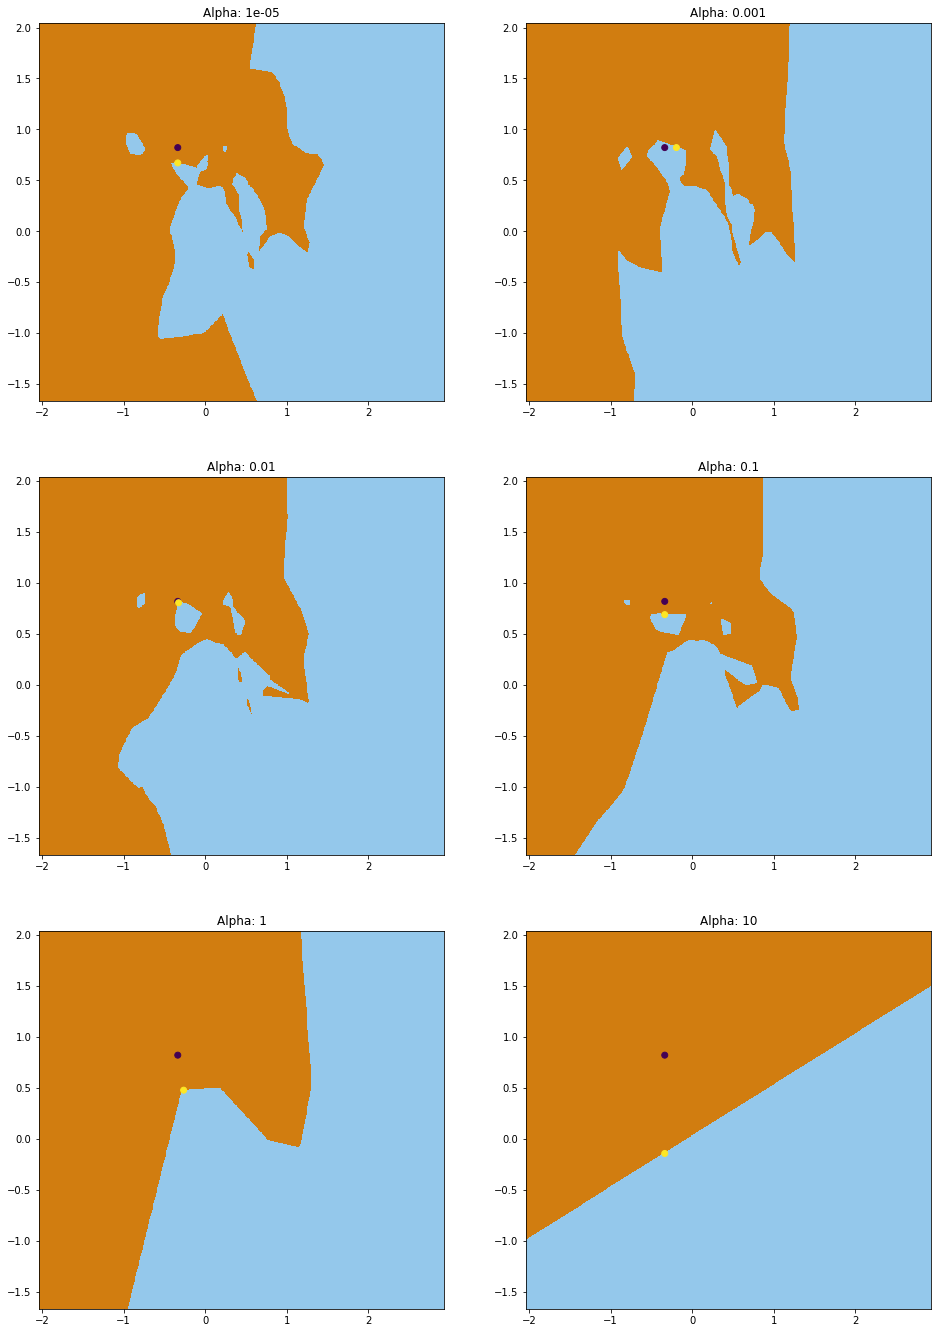

In [10]:
model_names = list(result['explanation'].keys())
plt.figure(figsize=(16, 32))

for i in range(len(alphas)):

    orig_point = result['explanation'][model_names[i]]['explanations'][0]['inputFeatures']
    cf_point = result['explanation'][model_names[i]]['explanations'][0]['bestIndividuals'][0]['data']
    cf_array = np.array([orig_point, cf_point])#.shape#.keys()

    clf = model_dict[model_names[i]]
    fig = plt.subplot(4, 2, i+1)
    plt.title('Alpha: {}'.format(alphas[i]))
    plot_decision_boundary(lambda x: clf.predict(x), X, y, cmap_back,None, fig,  X_cf = cf_array, y_cf = y_test[:2])

Above, we can see that the distance between the counterfactual and the original point change based on the model boundary. Certifai uses the distances in aggregate to calculate the Robustness and Fairness scores. 

The intuition behind the Robustness score is if original points are close to their counterfactuals, then they are also close to the decision boundary, which could be a sign of overfitting. 

The intuition behind the Fairness score is that if sugroups of people (defined by membership to protected groups) are farther away from their counterfactuals (on average), then this could be a sign of unfairness.

In [11]:
# We'll scan the test data to see how robustness changes
df_test = pd.DataFrame(X_test, columns=['income', 'credit_score'])
df_test['outcome'] = y_test

# Add the validation dataset
validation_dataset = CertifaiDataset('validation', CertifaiDatasetSource.dataframe(df_test))
scan_test.add_dataset(validation_dataset)
scan_test.add_evaluation_type('robustness')
scan_test.evaluation_dataset_id = 'validation'

# We'll also add accuracy
scan_test.add_evaluation_type('performance')
scan_test.add_metric(CertifaiModelMetric('accuracy', 'accuracy'))

scan_test.atx_performance_metric = 'accuracy'
scan_test.test_dataset_id='validation'

scan_test.dataset_schema.outcome_feature_name = 'outcome'

result_test = scan_test.run(write_reports=False)

[--------------------] 2020-09-24 16:01:45.830617 - 0 of 12 reports (0.0% complete) - Starting scan with model_use_case_id: 'sim_moon_test' and scan_id: 'aea041973421'
[--------------------] 2020-09-24 16:01:45.830724 - 0 of 12 reports (0.0% complete) - Running robustness evaluation for model: nn_1e05
[#-------------------] 2020-09-24 16:01:52.480360 - 1 of 12 reports (8.33% complete) - Running performance evaluation for model: nn_1e05
[###-----------------] 2020-09-24 16:01:52.484433 - 2 of 12 reports (16.67% complete) - Running robustness evaluation for model: nn_0001
[#####---------------] 2020-09-24 16:01:59.400490 - 3 of 12 reports (25.0% complete) - Running performance evaluation for model: nn_0001
[######--------------] 2020-09-24 16:01:59.405381 - 4 of 12 reports (33.33% complete) - Running robustness evaluation for model: nn_001
[########------------] 2020-09-24 16:02:05.876502 - 5 of 12 reports (41.67% complete) - Running performance evaluation for model: nn_001
[##########--

Next, we'll look at the Robustness and Performance scores, which in this case is accuracy.

In [12]:
stats_df = pd.DataFrame(columns=["alpha", "train_robustness", "train_accuracy", "test_robustness", "test_accuracy"])
for model in list(model_df.context):
    cols = ['alpha',
      'train robustness' ,
      'train accuracy',
     'test robustness',
      'test accuracy']
    vals = [model.split('_')[1], 
            round( result['atx'][model]['component_scores']['robustness'],2),
            result['performance'][model]['performance_metrics'][0]['score'],
            round( result_test['atx'][model]['component_scores']['robustness'],2),
            result_test['performance'][model]['performance_metrics'][0]['score']]    
    stats_dict = dict(zip(cols,vals))
    stats_df = stats_df.append({"alpha": stats_dict['alpha'], 
                                "train_robustness": stats_dict['train robustness'],
                               "train_accuracy": stats_dict['train accuracy'],
                                "test_robustness" : stats_dict['test robustness'],
                               "test_accuracy" : stats_dict['test accuracy']}, ignore_index=True
                              )
stats_df['alpha'] = alphas
stats_df
    

,alpha,train_robustness,train_accuracy,test_robustness,test_accuracy
0,0.00001,12.20,99.5,15.06,92.0
1,0.00100,11.18,99.0,9.94,84.0
2,0.01000,13.08,99.0,12.52,90.0
3,0.10000,13.22,99.5,15.62,94.0
4,1.00000,21.08,92.0,22.96,94.0
5,10.00000,53.41,83.0,53.37,86.0


The accuracy metrics reflect what we saw with the boundaries above; if alpha is small the accuracy on the training set is high, but the model does not generalize to the test set (i.e., low test accuracy). The models with larger alphas generalize better until you hit a tipping point where the model can no longer capture the complexity of the data, and it does poorly on both the training and test data (alpha = 10). The robustness scores tell a similar story: the scores are less than .15 where the value of alpha encourages a closer fit to othe data (alpha <= .1), and it jumps up to 21.09 when alpha is equal to 1. Based on the high accuracy on the training and test sets and the robustness measure, we would choose alpha to be equal to 1.

## Fairness analysis

Certifai allows you to examine implicit and explicit bias. In this part of the notebook we'll look at implicit bias and consider different relationships that could exist between a protected feature and the ground truth outcome. The protected feature is binary whose values can be A or B, and we'll construct the protected feature in the following ways:
1. The protected attribute and the ground truth outcome are identical
2. The protected attribute and the ground truth outcome are completely uncorrelated (i.e., the protected attribute value is determined by flipping a fair coin)
3. One subgroup within the protected attribute is more likely to have the favorable outcome in the ground truth than the other subgroup (group B is more likely to have the favorable outcome than group A)

We'll then examine the burden (we discuss burden in more depth [here](https://cognitivescale.github.io/cortex-certifai/docs/information/interp-scan-results-ds)) charts and the Fairness scores.

Alpha:  1 , Training accuracy:  0.92 , Test accuracy: 0.94


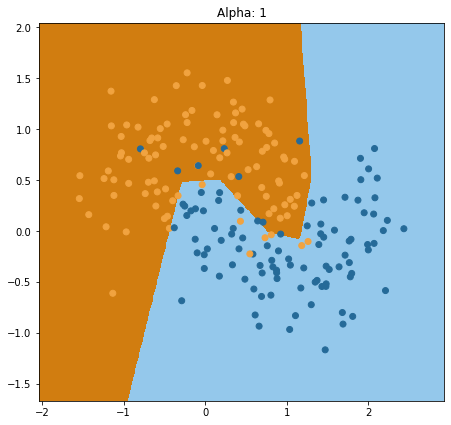

In [13]:
# We will look at the MLP where alpha seemed to not over or under fit
alpha = 1

model_df = pd.DataFrame(columns=["context","alpha"])
        

# Varying the hidden layer size to observe underfitting and overfitting
plt.figure(figsize=(16, 32))
fig = plt.subplot(4, 2, 1)
plt.title('Alpha: {}'.format(alpha))


clf = MLPClassifier(solver='lbfgs', alpha=alpha,
                             random_state=1, max_iter=2000,
                             early_stopping=True,
                             hidden_layer_sizes=[50,100])
clf.fit(X, y)

print("Alpha: ", alpha, ', Training accuracy: ', clf.score(X, y), ", Test accuracy:", clf.score(X_test, y_test))
    

plot_decision_boundary(lambda x: clf.predict(x), X, y, cmap_back, cm_bright, fig)

# Add our local models
wrapped_model = CertifaiPredictorWrapper(clf)#,encoder=encoder)
model_name = 'nn_{}'.format(alpha)
model_name = model_name.replace('.', '')
model_name = model_name.replace('-', '')

model_df = model_df.append({"context": model_name, 
                            "alpha": alpha}, ignore_index=True
                          )

cert_model = CertifaiModel(model_name, local_predictor=wrapped_model)

### Protected attribute is identical to ground truth outcome
First, we'll make the protected feature identical to the outcome column and run the Certifai scan. In this case, our intuition is that one group will have a much higher burden than the other group, and the overall fairness score will be close to zero.

In [14]:
df_unfair = df.copy()
df_unfair['Protected'] = y
feature_map = {1: 'B', 0: 'A'}
df_unfair['Protected'] = df_unfair['Protected'].map(feature_map)
df_unfair

scan_unfair = CertifaiScanBuilder.create('sim_moon_train',
                                  prediction_task=task)
scan_unfair.add_model(cert_model)

# Add the validation dataset
validation_dataset = CertifaiDataset('validation', CertifaiDatasetSource.dataframe(df_unfair))
scan_unfair.add_dataset(validation_dataset)
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by gender
scan_unfair.add_fairness_grouping_feature(CertifaiGroupingFeature('Protected'))
scan_unfair.add_evaluation_type('fairness')
scan_unfair.evaluation_dataset_id = 'validation'

#scan_fair.atx_performance_metric = 'accuracy'
scan_unfair.test_dataset_id='validation'

# We will look at Certifai's specific measure of unfairness, called burden, 
# but we can also look at two other commonly used measures of fairness
# called demographic parity and equal opportunity
# scan_fair.add_fairness_metric('demographic parity')
# scan_fair.add_fairness_metric('equal opportunity')

# since we did not use gender to train the model, we need to tell Certifai that it's a hidden feature
scan_unfair.dataset_schema.hidden_feature_names = ['Protected']

scan_unfair.dataset_schema.outcome_feature_name = 'outcome'

result_unfair = scan_unfair.run(write_reports=False)

[--------------------] 2020-09-24 16:06:36.124229 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'sim_moon_train' and scan_id: 'a698990e9ee8'
[--------------------] 2020-09-24 16:06:36.124508 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: nn_1
[####################] 2020-09-24 16:07:01.163796 - 1 of 1 reports (100.0% complete) - Completed all evaluations


Let's look at the burden plot and overall fairness score in the completely unfair case.

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (Protected),Feature (Protected) lower bound,Feature (Protected) upper bound,Group details (A),Group details (A) lower bound,Group details (A) upper bound,Group details (B),Group details (B) lower bound,Group details (B) upper bound
nn_1 (burden),nn_1,burden,7.169127,2.371643,13.995314,7.169127,2.371643,13.995314,0.22274,0.182698,0.253301,0.008127,0.002576,0.016697


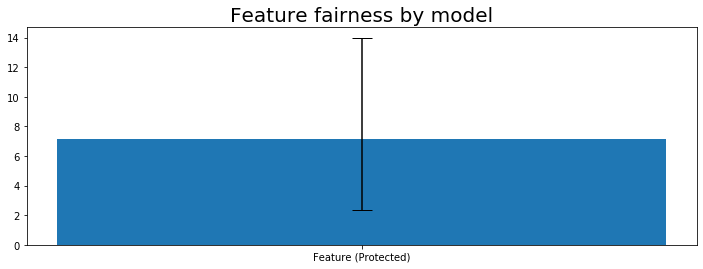

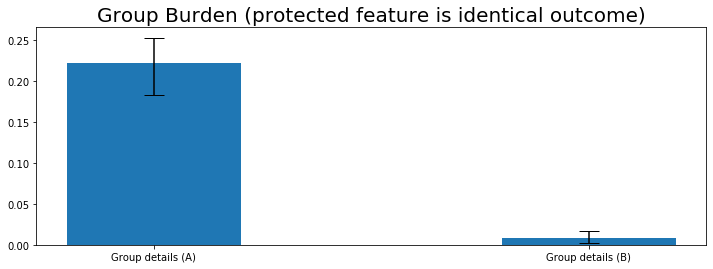

In [15]:
# Compare the fairness by feature measured for each model
df_result_unfair = construct_scores_dataframe(scores('fairness', result_unfair, max_depth=1))

display(df_result_unfair)

print("\n")

features = ['Feature (Protected)']
feature_scores = df_result_unfair[features]
feature_lower_bounds = df_result_unfair[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_unfair[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_unfair)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)


plt.show()


features = ['Group details (A)', 'Group details (B)']
feature_scores = df_result_unfair[features]
feature_lower_bounds = df_result_unfair[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_unfair[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Group Burden (protected feature is identical outcome)', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_unfair)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)


plt.show()

Our intuition was correct! According to this, group A has more difficulty attaining the favorable prediction from the model. Since models learn the boundary that will classify as many things correctly as possible and group A is identical to the group that has the unfavorable outcome in the ground truth, most of group A will be given the unfavorable prediction (true negatives). Here the distance between the original points and their counterfactuals will contribute to the burden. On the other side, most people in group B will receive the favorable prediction (true positives) and will contribute zero to the numerator. A small number of false negatives in group B will make the burden greater than zero. This is an extreme example of (implicit*) bias. 

\* Implicit because we did not use the protected feature to train the model.

## No association between protected attribute and ground truth outcome
In the next scenario, we’ve gone to the other extreme and made it so there is no association between the protected feature and the outcome by randomly assigning an A or a B to each observation in the dataset.

If the protected feature has no association with the ground truth outcome, we should see that the burden is roughly equal between group A and group B.

In [16]:
# Next we'll randomly assign a value for the protected attribute to every observation
feature_map = {True: 'B', False: 'A'}

df_uncorr = df.copy()
df_uncorr['Protected'] = ( np.random.uniform(0,1,df.shape[0]) > .5)
df_uncorr['Protected'] = df_uncorr['Protected'].map(feature_map)
df_uncorr
scan_fair_even = CertifaiScanBuilder.create('sim_moon_train',
                                  prediction_task=task)

scan_fair_even.add_model(cert_model)

# Add the validation dataset
validation_dataset = CertifaiDataset('validation', CertifaiDatasetSource.dataframe(df_uncorr))
scan_fair_even.add_dataset(validation_dataset)
# scan_fair_even.add_evaluation_type('robustness')
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by gender
scan_fair_even.add_fairness_grouping_feature(CertifaiGroupingFeature('Protected'))
scan_fair_even.add_evaluation_type('fairness')
scan_fair_even.evaluation_dataset_id = 'validation'

scan_fair_even.test_dataset_id='validation'

# You can also look at other measures of fairness
#scan_fair_even.add_fairness_metric('demographic parity')
#scan_fair_even.add_fairness_metric('equal opportunity')

scan_fair_even.dataset_schema.hidden_feature_names = ['Protected']


scan_fair_even.dataset_schema.outcome_feature_name = 'outcome'

result_fair_even = scan_fair_even.run(write_reports=False)

[--------------------] 2020-09-24 16:07:01.475457 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'sim_moon_train' and scan_id: 'd8c35b129408'
[--------------------] 2020-09-24 16:07:01.475805 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: nn_1
[####################] 2020-09-24 16:07:25.673850 - 1 of 1 reports (100.0% complete) - Completed all evaluations


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (Protected),Feature (Protected) lower bound,Feature (Protected) upper bound,Group details (A),Group details (A) lower bound,Group details (A) upper bound,Group details (B),Group details (B) lower bound,Group details (B) upper bound
nn_1 (burden),nn_1,burden,93.021066,80.419179,99.398914,93.021066,80.419179,99.398914,0.11279,0.085724,0.138831,0.117499,0.088665,0.149887


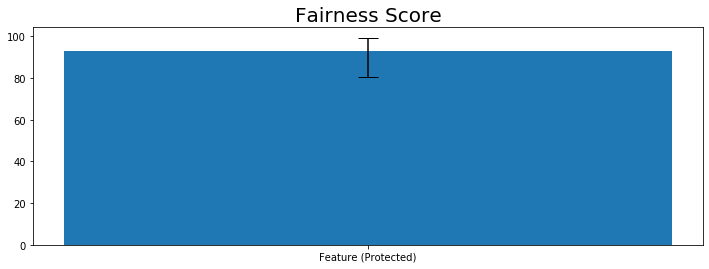

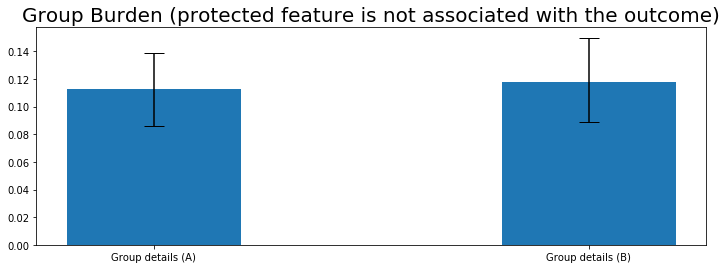

In [17]:
# Compare the fairness by feature measured for each model
df_result_fair = construct_scores_dataframe(scores('fairness', result_fair_even, max_depth=1))

display(df_result_fair)

print("\n")

features = ['Feature (Protected)']
feature_scores = df_result_fair[features]
feature_lower_bounds = df_result_fair[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_fair[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Fairness Score', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_fair)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)
plt.show()


features = ['Group details (A)', 'Group details (B)']
feature_scores = df_result_fair[features]
feature_lower_bounds = df_result_fair[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_fair[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Group Burden (protected feature is not associated with the outcome)', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_fair)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)


plt.show()

We see here that the burdens for group A and B are roughly equal (or at least their error bars are overlapping), which means it's not too difficult for either group to obtain the favorable prediction relative to the other group.


### Some correlation between protected group membership and ground truth outcome
However, in most situations the protected feature will not be perfectly correlated with the outcome in the ground truth or completely uncorrelated with the outcome. In most cases there will be some correlation between the protected feature and the outcome. To mimic this we divide the observations based on the favorable and unfavorable ground truth labels, and within each group, randomly draw the value of the protected feature with different probability. Specifically, we assign observations in the favorable group to be group A with 25%, and in the unfavorable group, we assign observations to be group A with 75% chance. Here is the burden plot for that situation:

In [18]:
df_favorable = df[df.outcome == 1].copy() 
df_favorable['Protected'] = ( np.random.uniform(0,1,df_favorable.shape[0]) > .25).astype(int)
df_unfavorable = df[df.outcome == 0].copy() 
df_unfavorable['Protected'] = (np.random.uniform(0,1,df_unfavorable.shape[0]) > .75).astype(int)

df_partial_corr = pd.concat((df_favorable, df_unfavorable), axis = 0)

df_partial_corr['Protected'] = df_partial_corr['Protected'].map(feature_map)
table = pd.crosstab(df_partial_corr['Protected'],df_partial_corr['outcome'])

# Let's look at the distribution
table



outcome,0,1
Protected,,
A,81,26
B,19,74


In [19]:
scan_partial_corr = CertifaiScanBuilder.create('sim_moon_train',
                                  prediction_task=task)

scan_partial_corr.add_model(cert_model)

# Add the validation dataset
validation_dataset = CertifaiDataset('validation', CertifaiDatasetSource.dataframe(df_partial_corr))
scan_partial_corr.add_dataset(validation_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by gender
scan_partial_corr.add_fairness_grouping_feature(CertifaiGroupingFeature('Protected'))
scan_partial_corr.add_evaluation_type('fairness')
scan_partial_corr.evaluation_dataset_id = 'validation'

scan_partial_corr.test_dataset_id='validation'

# You can also look at other measures of fairness
#scan_fair_even.add_fairness_metric('demographic parity')
#scan_fair_even.add_fairness_metric('equal opportunity')

scan_partial_corr.dataset_schema.hidden_feature_names = ['Protected']


scan_partial_corr.dataset_schema.outcome_feature_name = 'outcome'

result_partial_corr = scan_partial_corr.run(write_reports=False)

[--------------------] 2020-09-24 16:07:26.002678 - 0 of 1 reports (0.0% complete) - Starting scan with model_use_case_id: 'sim_moon_train' and scan_id: '336ea008f7f1'
[--------------------] 2020-09-24 16:07:26.002895 - 0 of 1 reports (0.0% complete) - Running fairness evaluation for model: nn_1
[####################] 2020-09-24 16:07:50.591261 - 1 of 1 reports (100.0% complete) - Completed all evaluations


,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (Protected),Feature (Protected) lower bound,Feature (Protected) upper bound,Group details (A),Group details (A) lower bound,Group details (A) upper bound,Group details (B),Group details (B) lower bound,Group details (B) upper bound
nn_1 (burden),nn_1,burden,41.789661,27.018751,56.131344,41.789661,27.018751,56.131344,0.175007,0.14068,0.206212,0.045638,0.027788,0.06673


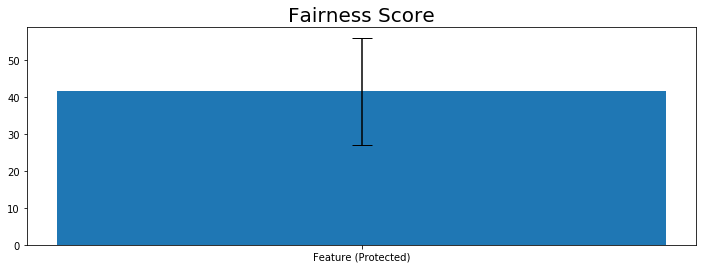

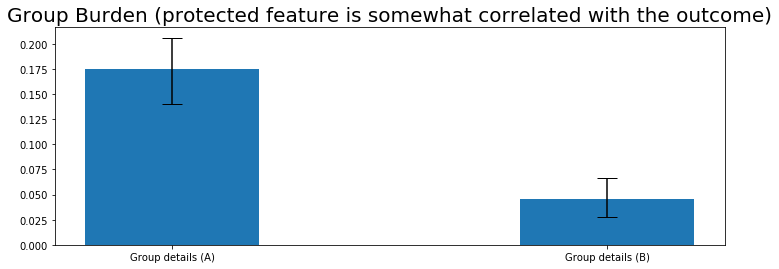

In [20]:
# Compare the fairness by feature measured for each model
df_result_partial_corr = construct_scores_dataframe(scores('fairness', result_partial_corr, max_depth=1))

display(df_result_partial_corr)

print("\n")

features = ['Feature (Protected)']
feature_scores = df_result_partial_corr[features]
feature_lower_bounds = df_result_partial_corr[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_partial_corr[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Fairness Score', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_partial_corr)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

plt.show()


features = ['Group details (A)', 'Group details (B)']
feature_scores = df_result_partial_corr[features]
feature_lower_bounds = df_result_partial_corr[[f + ' lower bound' for f in features]]
feature_upper_bounds = df_result_partial_corr[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Group Burden (protected feature is somewhat correlated with the outcome)', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df_result_partial_corr)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

#ax.legend()
plt.show()

In this situation we can visually tell that there is a difference between the burdens between the two groups with group A having a burden of around .175 and group B having a burden of around .05. It's not as extreme as the first case we looked at, but there is definitely still a difference between groups.

However, comparing these burden plots across models becomes unwieldy quickly, which is why we use the burden values to calculate a normalized Fairness score. The Fairness score is a gini-like index between 0 and 100 that essentially measures how unequal the burden values are across groups. A score of 0 means the model is exhibiting the highest bias and a score of 100 means the model is perfectly fair. 

The table below shows the Fairness score for each scenario above:


In [21]:
# Let's look at the overall Fairness scores for each of these situations
df_result_unfair['type'] = 'Protected feature determines outcome'
df_result_fair['type'] = "Protected feature not related to outcome"
df_result_partial_corr['type'] = "Protected feature partially related to outcome"
df_result_all = pd.concat((df_result_unfair, df_result_partial_corr, df_result_fair), axis = 0)
df_result_all = df_result_all.reset_index()
df_result_all[['type', 'overall fairness','overall fairness lower bound',
       'overall fairness upper bound']]

,type,overall fairness,overall fairness lower bound,overall fairness upper bound
0,Protected feature determines outcome,7.169127,2.371643,13.995314
1,Protected feature partially related to outcome,41.789661,27.018751,56.131344
2,Protected feature not related to outcome,93.021066,80.419179,99.398914


Having seen the burden plots, the overall fairness scores match up with our expectations. In the case where the protected feature is identical to the ground truth outcome, the number is close to zero. When there is some association between the protected attribute and the ground truth outcome then the fairness score is around 42, and when there is no association between the protected attribute and the ground truth label, the score is around 93.